In [1]:
import os
import cv2
import tempfile
import numpy as np
import tensorflow as tf
print(tf.__version__ )

2.17.0


In [2]:
#@title Downloading and extracting the model checkpoints

MODEL_NAME = "mobilenetv3_large_cityscapes_trainfine" #@param ["mobilenetv3_large_cityscapes_trainfine", "xception65_cityscapes_trainfine"]

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'mobilenetv3_large_cityscapes_trainfine':
        'deeplab_mnv3_large_cityscapes_trainfine_2019_11_15.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}

MODEL_TAR = MODEL_URLS[MODEL_NAME]
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_TAR

# Download
!wget -O {MODEL_TAR} {MODEL_URL}

# Extract
MODEL_FILE = !tar -zxvf {MODEL_TAR} --wildcards --no-anchored 'frozen_inference_graph.pb'
MODEL_FILE = MODEL_FILE[0].strip()

--2024-10-21 00:27:25--  http://download.tensorflow.org/models/deeplabv3_cityscapes_train_2018_02_06.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.141.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460310119 (439M) [application/x-tar]
Saving to: ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’

deeplabv3_cityscape 100%[===================>] 438.99M   109MB/s    in 4.1s    

2024-10-21 00:27:29 (107 MB/s) - ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’ saved [460310119/460310119]



In [3]:
# Load the TensorFlow model
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph
# because some operations (ArgMax) might not support the delegates.
# Insepct the graph using Netron https://lutzroeder.github.io/netron/
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE,
    input_arrays = ['sub_7'], # For the Xception model it needs to be `sub_7`, for MobileNet it would be `sub_2`
    output_arrays = ['ResizeBilinear_2']
)

# Optional: Perform the simplest optimization known as post-training dynamic range quantization.
# https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
# You can refer to the same document for other types of optimizations.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert to TFLite Model
tflite_model = converter.convert()

_, tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training dynamic range quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  165712950 bytes
TFLite Model is      42565736 bytes
Post training dynamic range quantization saves 123147214 bytes


In [4]:
!ls -lh {tflite_path}

-rw------- 1 root root 41M Oct 21 00:28 /tmp/tmp1rw4sqte.tflite


In [5]:
from google.colab import files
files.download(tflite_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**load TFLite model**

In [6]:
interpreter= tf.lite.Interpreter(model_path=tflite_path)#load model
#set model input
input_details =  interpreter.get_input_details()
interpreter.allocate_tensors()
#image size
input_size =input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(2049, 1025)


**preprocess**

In [7]:
from PIL import Image, ImageOps

def preprocess(image_path):

  image= Image.open(image_path)
  intial_size= image.size
  desired_ratio= input_size[0] / input_size[1]
  intial_ratio= intial_size[0] / intial_size[1]

  if intial_ratio < desired_ratio:
    new_size= intial_size[0], int(intial_size[0] / desired_ratio)
  else:
    new_size= int(intial_size[1]* desired_ratio), intial_size[1]

  #cropping & resizing to desired ratio and size
  delta_w = new_size[0] - intial_size[0]
  delta_h = new_size[1] - intial_size[1]
  padding = (delta_w//2, delta_h//2, delta_w - (delta_w//2), delta_h - (delta_h//2))
  cropped_iamge = ImageOps.expand(image, padding)
  resized_image = cropped_iamge.convert('RGB').resize(input_size, Image.BILINEAR)

  #adding batch dim , normalization , convert to array
  im =np.asarray(resized_image).astype(np.float32)
  im =np.expand_dims(im, axis=0)
  im = im / 127.5 - 1
  return im, cropped_iamge.size

**inference**

In [8]:
def preprocess(image_path):
    # Load and process image
    image = Image.open(image_path)
    initial_size = image.size
    desired_ratio = input_size[0] / input_size[1]
    initial_ratio = initial_size[0] / initial_size[1]

    if initial_ratio < desired_ratio:
        new_size = (initial_size[0], int(initial_size[0] / desired_ratio))
    else:
        new_size = (int(initial_size[1] * desired_ratio), initial_size[1])

    # Calculate padding if needed
    delta_w = new_size[0] - initial_size[0]
    delta_h = new_size[1] - initial_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    cropped_image = ImageOps.expand(image, padding)
    resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)

    # Convert to array, normalize, and expand dims
    im = np.asarray(resized_image).astype(np.float32)
    im = np.expand_dims(im, axis=0)  # Add batch dimension
    im = im / 127.5 - 1  # Normalize between [-1, 1]

    return im, cropped_image.size

def inference(image_path):
    # Preprocess the image
    im = preprocess(image_path)[0]

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], im)

    # Invoke the interpreter to run inference
    interpreter.invoke()

    # Retrieve the raw output map
    output_details = interpreter.get_output_details()

    # Make a copy of the tensor output to avoid holding reference to internal data
    raw_output_map = np.array(interpreter.get_tensor(output_details[0]['index']))  # Copy the raw prediction

    # Post-processing: resize the output and apply ArgMax to get the segmentation map
    width, height = preprocess(image_path)[1]  # Get the size of the cropped image
    raw_output_map_resized = tf.image.resize(raw_output_map, (height, width))
    segmentation_map = tf.argmax(raw_output_map_resized, axis=3)

    # Squeeze to remove the extra batch dimension and convert to numpy
    segmentation_map = tf.squeeze(segmentation_map).numpy().astype(np.int8)

    return segmentation_map


**sky segmentation**

In [9]:
def segment_sky(seg_map):
  class_sky = 10
  sky_mask = (seg_map == class_sky).astype(np.uint8)  #Create a binary mask
  return sky_mask

**visualize**

In [25]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2

def visualize_sky_mask(image_path, seg_map):
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image_np = np.array(original_image)
    original_height, original_width, _ = original_image_np.shape

    # Resize segmentation map to match the original image size
    seg_map_resized = np.array(Image.fromarray(seg_map.astype(np.uint8)).resize((original_width, original_height), Image.NEAREST))

    # Create a binary mask of the sky
    sky_mask = segment_sky(seg_map_resized)

    # Create an RGB image to visualize the sky mask in blue
    sky_mask_colored = np.zeros_like(original_image_np)  # Initialize an all-black image
    sky_mask_colored[sky_mask == 1] = [70, 130, 180]  # Set the sky area to blue

    # Plot the original image and the sky mask
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Sky Segmentation Mask
    plt.subplot(1, 2, 2)
    plt.imshow(sky_mask_colored)
    plt.title("Sky Segmentation Mask (Blue Sky)")
    plt.axis("off")

    plt.show()

In [33]:
from google.colab import files
uploaded = files.upload()


Saving sky.jpeg to sky.jpeg


In [34]:
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)
seg_map = inference(image_path)

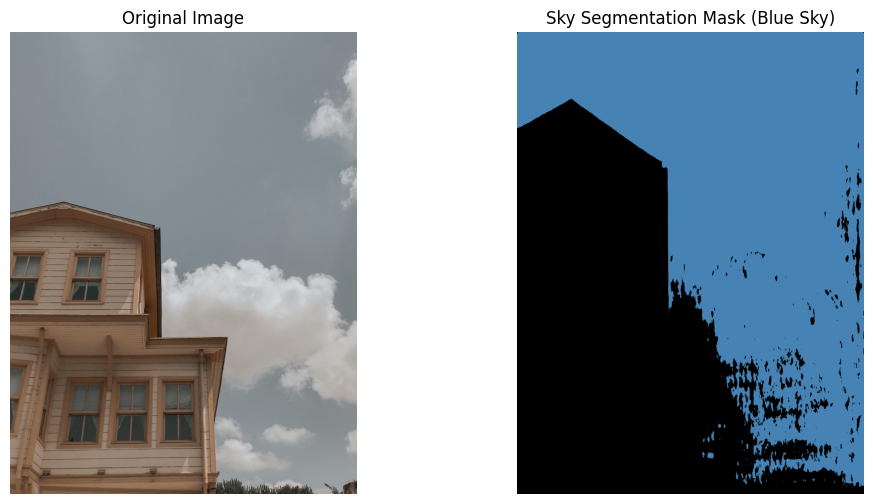

In [35]:
sky_mask= segment_sky(seg_map)
visualize_sky_mask(image_path, seg_map)